In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller
sns.set_theme(style='darkgrid')

In [2]:
from data import get_price_data
from backtest import backtest_strat
from helpers import resume_backtest, performance_plot, annual_alpha_plot, price_to_perf, correlation, \
                    pred_to_perf, prob_to_pred, prob_to_pred_2
from test import get_training_processed_data
from sklearn.model_selection import train_test_split

In [3]:
price, bench_price, df_X = get_price_data()
daily_returns = price.pct_change().shift(1)

In [4]:
rebalance_freq = 'W-FRI'
returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1)

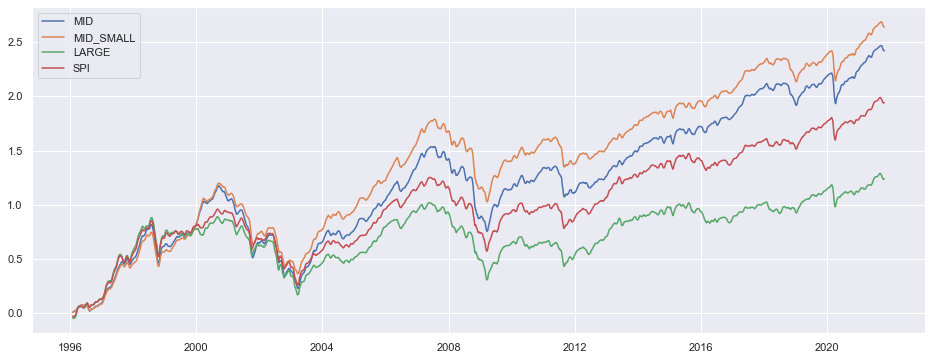

In [5]:
fig, ax = plt.subplots(figsize=(16,6))
best_perf = pred_to_perf(best_pred, daily_returns=daily_returns, log=True)
data_plot = np.log((pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).reindex(best_perf.index).cumprod().rolling(20).mean())
sns.lineplot(data=data_plot, dashes=False)
plt.show()

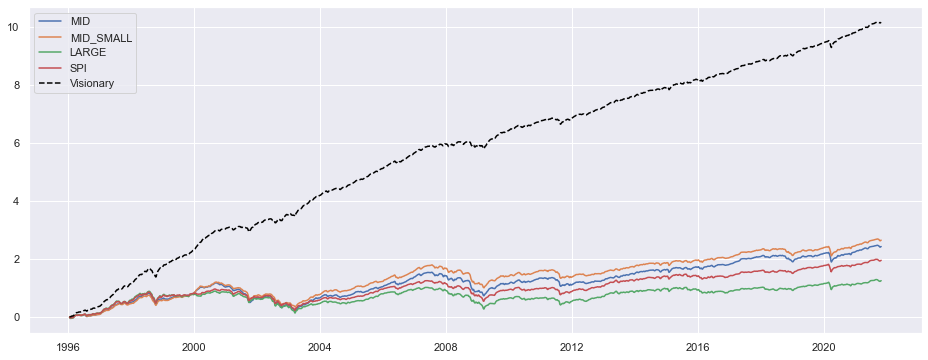

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
best_perf = np.log(pred_to_perf(best_pred, daily_returns=daily_returns).rolling(10).mean())
data_plot = np.log((pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).reindex(best_perf.index).cumprod().rolling(10).mean())
sns.lineplot(data=data_plot, dashes=False)
sns.lineplot(data=best_perf, color='black', linestyle='--', label='Visionary')
plt.legend()
plt.show()

In [7]:
data_stats = pd.concat([price, bench_price], axis=1)
data_annual_ret = data_stats.pct_change().mean() * 252 * 100
data_annual_std = data_stats.pct_change().std() * np.sqrt(252) * 100
data_annual_sharpe = data_annual_ret.div(data_annual_std)
data_stats = pd.concat([data_annual_ret, data_annual_std, data_annual_sharpe], axis=1)
data_stats.columns = ['Annualized average return', 'Annualized Std', 'Sharpe Ratio']
data_stats.round(2)

Annualized average return  Annualized Std  Sharpe Ratio
MID                            10.26           15.07          0.68
MID_SMALL                      10.89           13.71          0.79
LARGE                           6.38           18.16          0.35
SPI                             8.81           17.06          0.52

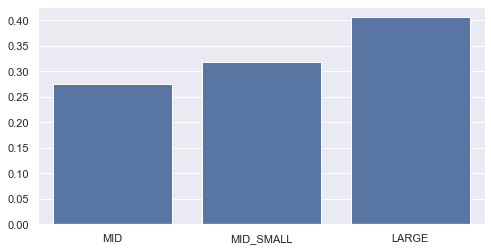

In [8]:
L = len(best_pred)
df_results = (best_pred.sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

### Large cap weekly outperformance appears more frequently than mid or small cap, even though it underperforms in long horizon => we better catch small and mid cap outperformance signals instead of large cap ones

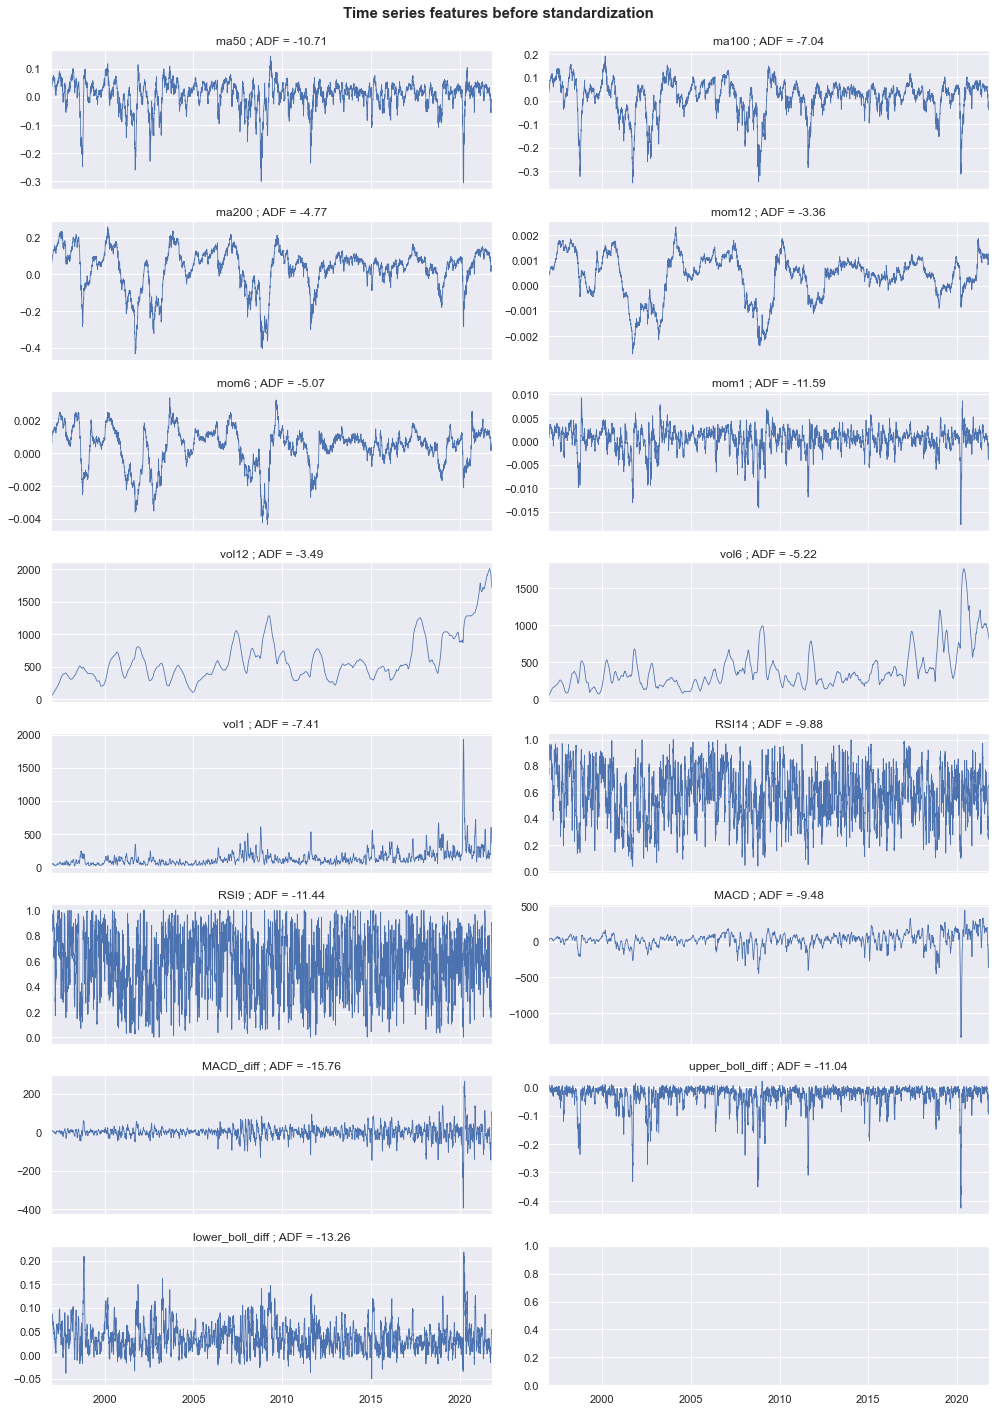

In [9]:
data_plot = df_X.iloc[:, df_X.columns.get_level_values(0) == 'MID']
data_plot.columns = data_plot.columns.get_level_values(1)

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(number_feature // 2 + (number_feature % 2 > 0), 2, figsize=(14, 20), sharex=True)
axs = axs.ravel()
for i, col in enumerate(data_plot.columns):
    results = adfuller(data_plot[col].values)
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col + f' ; ADF = {results[0]:.2f}')
    
plt.suptitle('Time series features before standardization', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

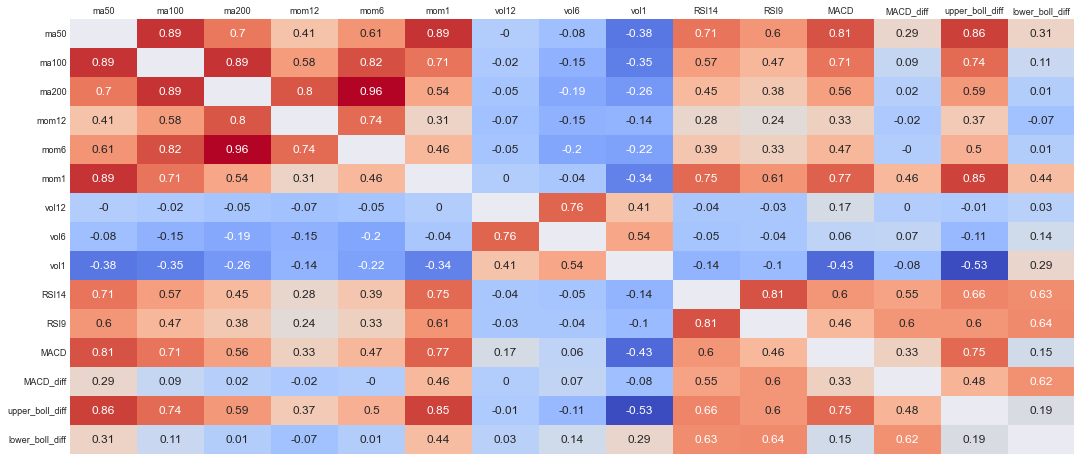

In [10]:
corr = data_plot.corr().round(2)

fig, ax = plt.subplots(figsize=(18,8))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=9, labelbottom=False, labeltop=True, length=0)
plt.show()

# BACKTEST

In [11]:
# models_list = ['MLP', 'ConvNet', 'LSTM']
# models_list = ['MLP', 'ConvNet']
models_list = ['MLP']
df_pred_dict = {}
df_prob_dict = {}

threshold = 0.8
batch_size = 10
verbose = 0
training_window = 8
nb_epochs = 2
rebalance_freq = 'W-FRI'
input_period_days = 42
input_period_weeks = 8
eta = 5e-3
weight_decay = 1e-4

if rebalance_freq == 'M':
    input_period = input_period_weeks
else:
    input_period = input_period_days

for i, model_name in enumerate(models_list):
    df_prob_dict[model_name] = backtest_strat(df_input_all=df_X, price=price, rebalance_freq=rebalance_freq, 
                                              model_name=model_name, nb_epochs=nb_epochs, 
                                              input_period=input_period, 
                                              batch_size=batch_size, verbose=verbose, 
                                              training_window=training_window, threshold=threshold, 
                                              eta=eta, weight_decay=weight_decay)
    df_pred_dict[model_name] = prob_to_pred(df_prob_dict[model_name], threshold)

    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]

df_prob_dict['Ensemble'] /= len(models_list)
df_pred_dict['Ensemble'] = prob_to_pred(df_prob_dict['Ensemble'], threshold)

Backtesting model MLP


100%|██████████| 34/34 [00:07<00:00,  4.33it/s]


In [12]:
df_pred = df_pred_dict['MLP']
tax = 0.0012

first_date = df_pred.index[0]
last_date = df_pred.index[-1]
daily_ret = daily_returns.loc[first_date:last_date]
df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
df_daily_perf = (df_pred_daily * daily_ret).sum(axis=1)
df_cost = (df_pred_daily.diff().fillna(0) != 0).any(axis=1).astype(int) * tax
perf_gross = (1 + df_daily_perf - df_cost).cumprod()

average_year_return_gross = df_daily_perf.pct_change().mean() * 252 * 100
average_year_return_net = (df_daily_perf - df_cost).pct_change().mean() * 252 * 100

average_year_std = df_daily_perf.pct_change().std() * np.sqrt(256) * 100
average_year_sharpe = average_year_return_net / average_year_std

dd_window = 252
roll_max = perf_gross.rolling(dd_window).max()
daily_dd = perf_gross / roll_max - 1
max_daily_dd = np.abs(daily_dd.rolling(dd_window, min_periods=1).min()).max() * 100

In [13]:
threshold = 0.6
df_pred_dict = {}
df_pred_dict_2 = {}
for model_name in df_prob_dict:
    df_pred_dict[model_name] = prob_to_pred(df_prob_dict[model_name], threshold)
    df_pred_dict_2[model_name] = prob_to_pred_2(df_prob_dict[model_name])
    
df_pred_dict_2['Visionary'] = best_pred

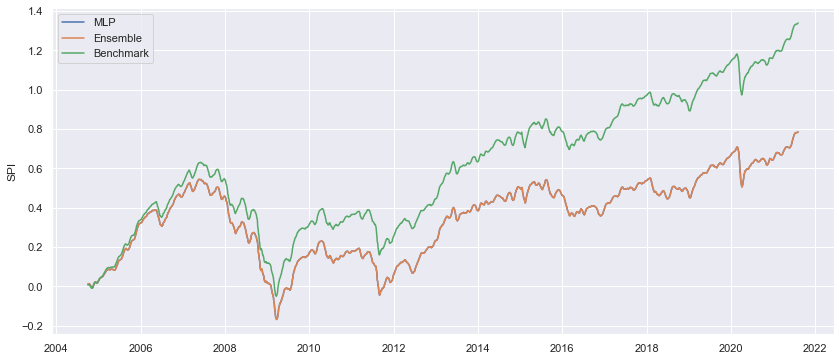

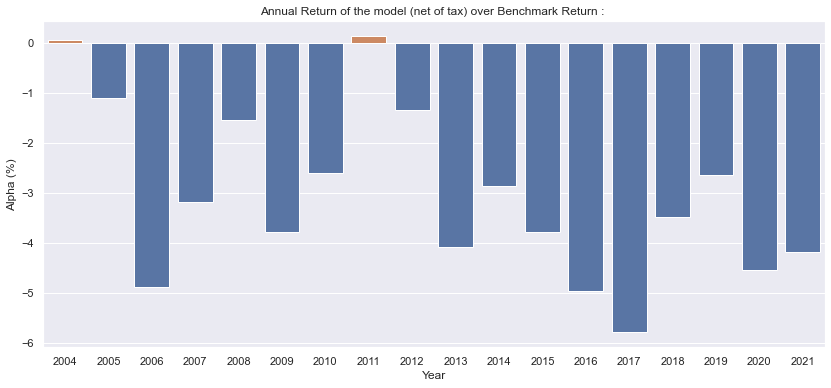

Gross avg. annual return (%)  Net avg. annual return (%)  Avg. annual vol. (%)  Avg Sharpe ratio  Max. Drawdown (%)  Turnover
Benchmark SPI                          9.04                        9.04                 16.29              0.55              44.52         0
MLP                                    5.94                        5.94                 16.93              0.35              44.62         0
Ensemble                               5.94                        5.94                 16.93              0.35              44.62         0

In [14]:
df_resume = resume_backtest(df_pred_dict, bench_price, price)
daily_returns = price.pct_change().shift(1)
perf_bench = price_to_perf(bench_price.loc[df_pred_dict['Ensemble'].index[0]:df_pred_dict['Ensemble'].index[-1]], log=False)
performance_plot(df_pred_dict, daily_returns, bench_price, log=True)
annual_alpha_plot(perf_bench, df_pred_dict['Ensemble'], daily_returns)
display(df_resume)

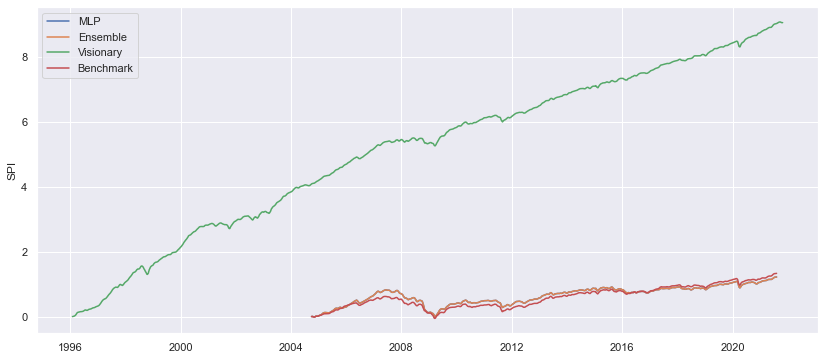

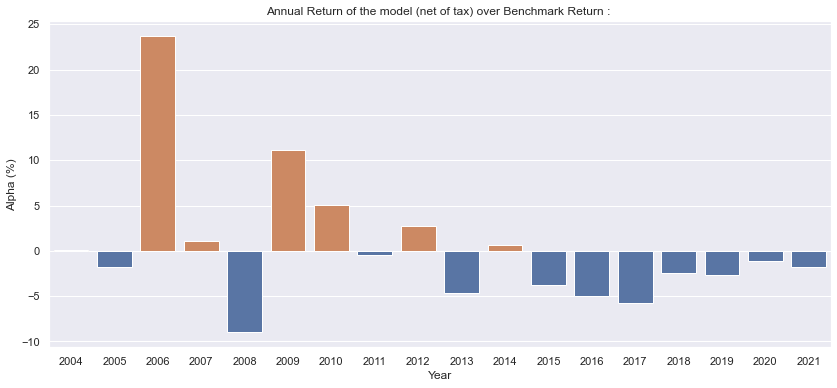

Gross avg. annual return (%)  Net avg. annual return (%)  Avg. annual vol. (%)  Avg Sharpe ratio  Max. Drawdown (%)  Turnover
Benchmark SPI                          9.04                        9.04                 16.29              0.55              44.52         0
MLP                                    8.87                        8.26                 15.71              0.53              48.28        89
Ensemble                               8.87                        8.26                 15.71              0.53              48.28        89
Visionary                             39.42                       35.33                 16.17              2.18              30.54       911

In [15]:
df_resume = resume_backtest(df_pred_dict_2, bench_price, price)
daily_returns = price.pct_change().shift(1)
perf_bench = price_to_perf(bench_price.loc[df_pred_dict['Ensemble'].index[0]:df_pred_dict['Ensemble'].index[-1]], log=False)
performance_plot(df_pred_dict_2, daily_returns, bench_price, log=True)
annual_alpha_plot(perf_bench, df_pred_dict_2['Ensemble'], daily_returns)
display(df_resume)

In [16]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df = df.astype(float)
df.round(2)

MLP
MLP  1.0

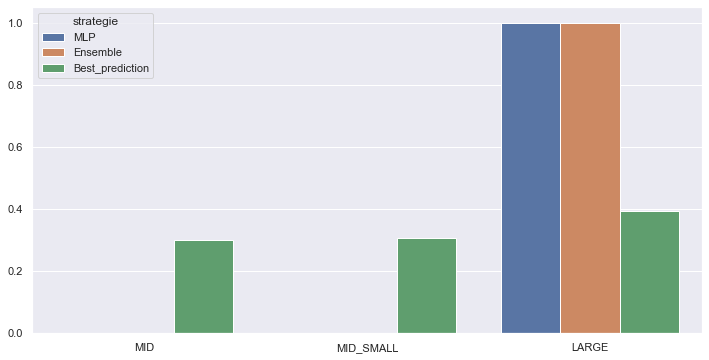

In [17]:
df_results = pd.DataFrame()

for model_name in df_pred_dict:
    L = len(df_pred_dict[model_name])
    df_results = pd.concat([df_results, (df_pred_dict[model_name].sum(axis=0) / L).rename(model_name)], axis=1)

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]]

df_results = pd.concat([df_results, (best_pred.sum(axis=0) / L).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

In [18]:
model

NameError: name 'model' is not defined